In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from cv2 import imread, createCLAHE
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import os

#********************************************
#**************to complete*******************
#********************************************
image_path = os.path.join("") #path to images: the source from data preparation
mask_path = os.path.join("") #path to masks: the mask from data preparation
path_where_to_save_model = '' #without the /

In [2]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [3]:
print(len(image_file_name))
print(len(mask))
print(len(images))

704
704
801


In [4]:
#testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
testing_files = mask[604:]
training_files = mask[:604]

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in testing_files:
            print(i)
            im = cv2.resize(cv2.imread(os.path.join(image_path, i.split("_mask")[0]+".png")), (X_shape, X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]   
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array, mask_array
    
    if flag == "train":
        for i in training_files:
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]
            im_array.append(im)
            mask_array.append(mask)
            
        return im_array, mask_array
            
        

In [5]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
    for i in range(0,6,3):
        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [6]:
dim = 128
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

MCUCXR_0053_0
MCUCXR_0054_0
MCUCXR_0055_0
MCUCXR_0056_0
MCUCXR_0057_0
MCUCXR_0058_0
MCUCXR_0059_0
MCUCXR_0060_0
MCUCXR_0061_0
MCUCXR_0062_0
MCUCXR_0063_0
MCUCXR_0064_0
MCUCXR_0068_0
MCUCXR_0069_0
MCUCXR_0070_0
MCUCXR_0071_0
MCUCXR_0072_0
MCUCXR_0074_0
MCUCXR_0075_0
MCUCXR_0077_0
MCUCXR_0079_0
MCUCXR_0080_0
MCUCXR_0081_0
MCUCXR_0082_0
MCUCXR_0083_0
MCUCXR_0084_0
MCUCXR_0085_0
MCUCXR_0086_0
MCUCXR_0087_0
MCUCXR_0089_0
MCUCXR_0090_0
MCUCXR_0091_0
MCUCXR_0092_0
MCUCXR_0094_0
MCUCXR_0095_0
MCUCXR_0096_0
MCUCXR_0097_0
MCUCXR_0099_0
MCUCXR_0100_0
MCUCXR_0101_0
MCUCXR_0102_0
MCUCXR_0103_0
MCUCXR_0104_1
MCUCXR_0108_1
MCUCXR_0113_1
MCUCXR_0117_1
MCUCXR_0126_1
MCUCXR_0140_1
MCUCXR_0141_1
MCUCXR_0142_1
MCUCXR_0144_1
MCUCXR_0150_1
MCUCXR_0162_1
MCUCXR_0166_1
MCUCXR_0170_1
MCUCXR_0173_1
MCUCXR_0182_1
MCUCXR_0188_1
MCUCXR_0194_1
MCUCXR_0195_1
MCUCXR_0196_1
MCUCXR_0203_1
MCUCXR_0213_1
MCUCXR_0218_1
MCUCXR_0223_1
MCUCXR_0228_1
MCUCXR_0243_1
MCUCXR_0251_1
MCUCXR_0253_1
MCUCXR_0254_1
MCUCXR_0255_1
MCUCXR

In [7]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

604 604 100 100


training set


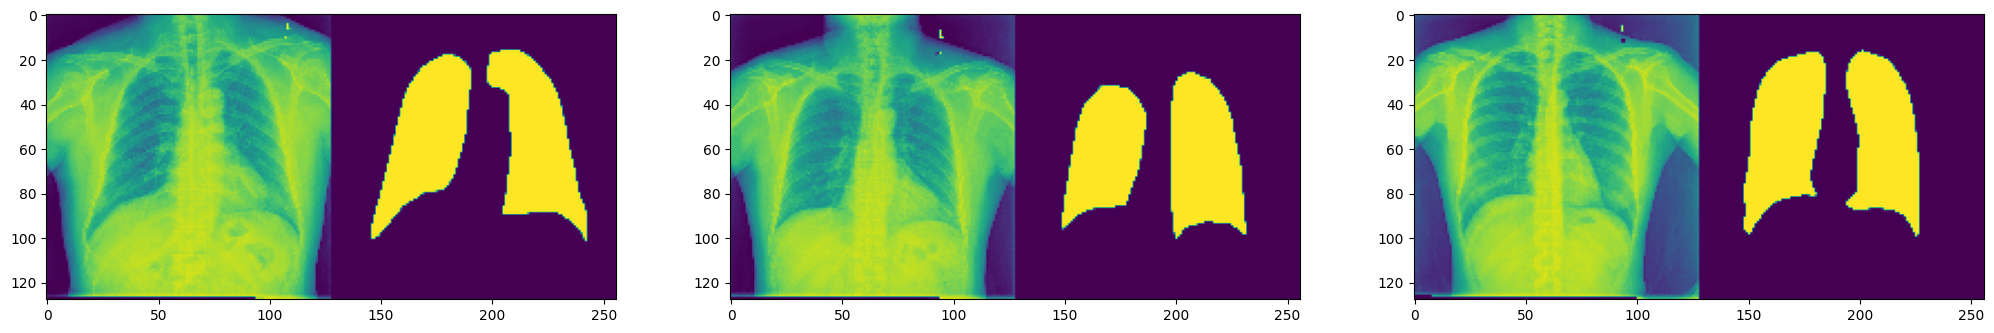

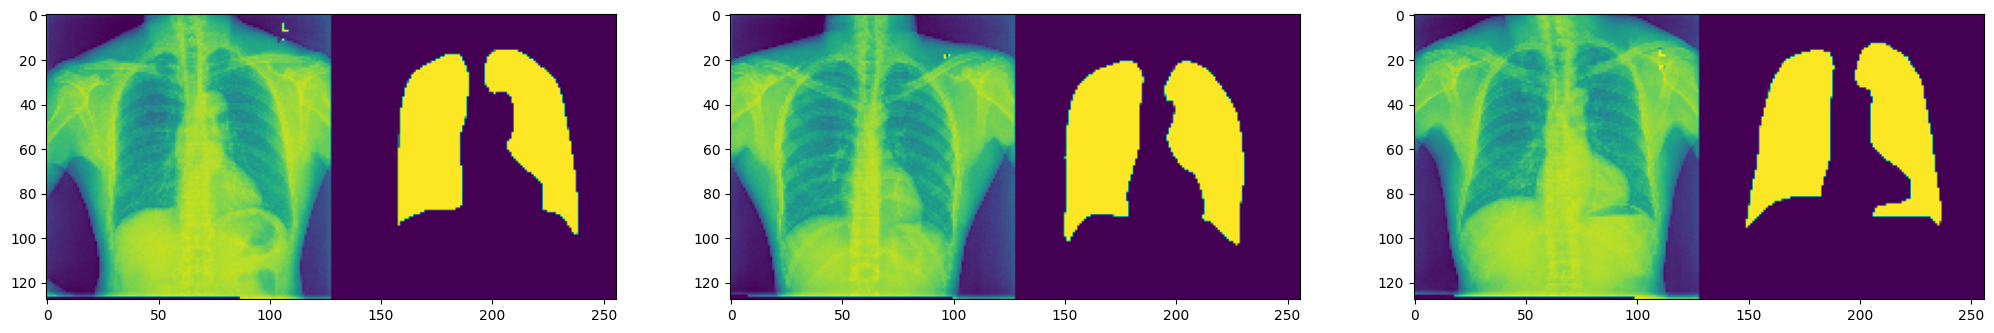

testing set


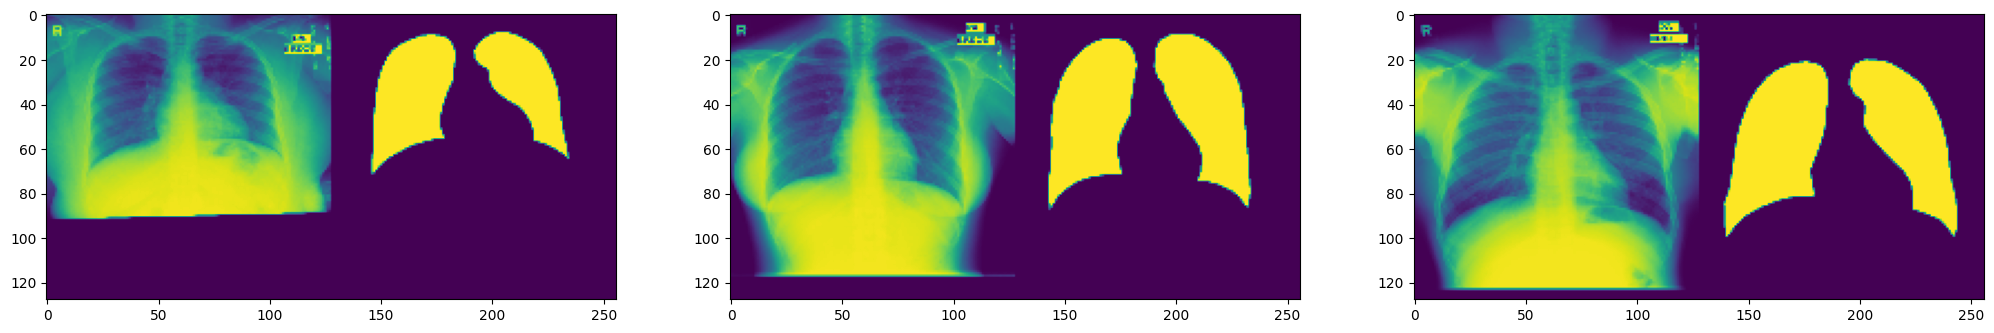

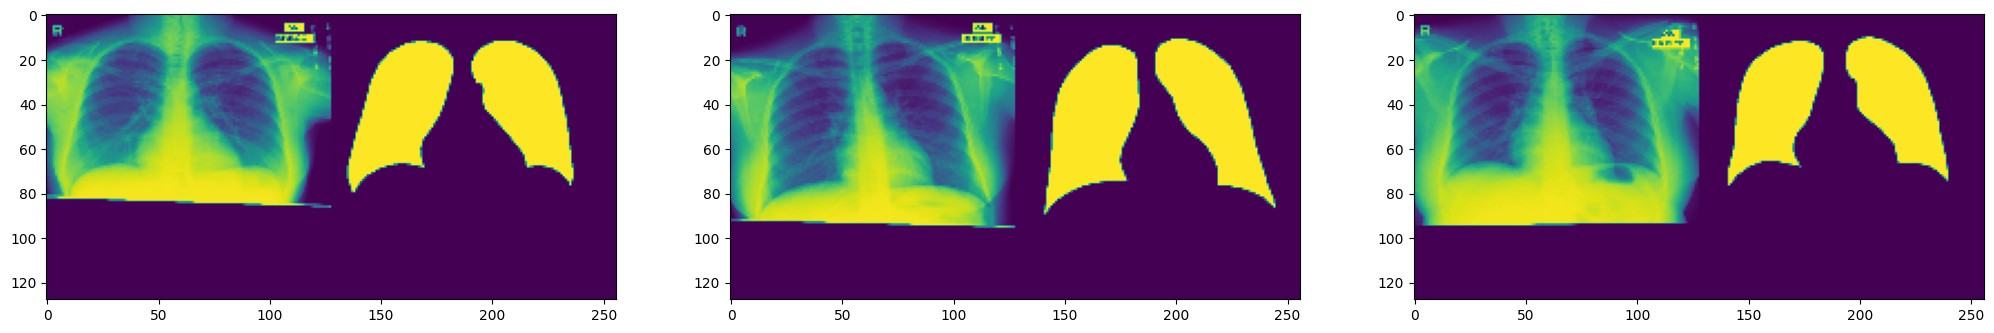

In [8]:
print("training set")
plotMask(X_train, y_train)
print("testing set")
plotMask(X_test, y_test)

In [9]:
X_train = np.array(X_train).reshape(len(X_train), dim, dim, 1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [10]:
print(images.shape)
print(mask.shape)

(704, 128, 128, 1)
(704, 128, 128, 1)


In [11]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [12]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [14]:
model = unet(input_size = (128,128,1))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), loss=dice_coef_loss,
             metrics = [dice_coef, 'binary_accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path=path_where_to_save_model+"/{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [17]:
from sklearn.model_selection import train_test_split
train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)
print(train_vol.shape)
print(validation_vol.shape)
print(test_vol.shape)

(569, 128, 128, 1)
(71, 128, 128, 1)
(64, 128, 128, 1)


In [16]:
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 50,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

#clear_output()


Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: -0.5484 - dice_coef: 0.5514 - binary_accuracy: 0.7228
Epoch 1: val_loss improved from inf to -0.69941, saving model to K:/Docs/stage_ingenieur/models/segmentation\cxr_reg_weights.best.hdf5
36/36 [==============================] - 52s 1s/step - loss: -0.5484 - dice_coef: 0.5514 - binary_accuracy: 0.7228 - val_loss: -0.6994 - val_dice_coef: 0.6994 - val_binary_accuracy: 0.8790 - lr: 0.0010
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: -0.8800 - dice_coef: 0.8805 - binary_accuracy: 0.9405
Epoch 2: val_loss improved from -0.69941 to -0.91360, saving model to K:/Docs/stage_ingenieur/models/segmentation\cxr_reg_weights.best.hdf5
36/36 [==============================] - 44s 1s/step - loss: -0.8800 - dice_coef: 0.8805 - binary_accuracy: 0.9405 - val_loss: -0.9136 - val_dice_coef: 0.9136 - val_binary_accuracy: 0.9582 - lr: 0.0010
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: -0.9250 -

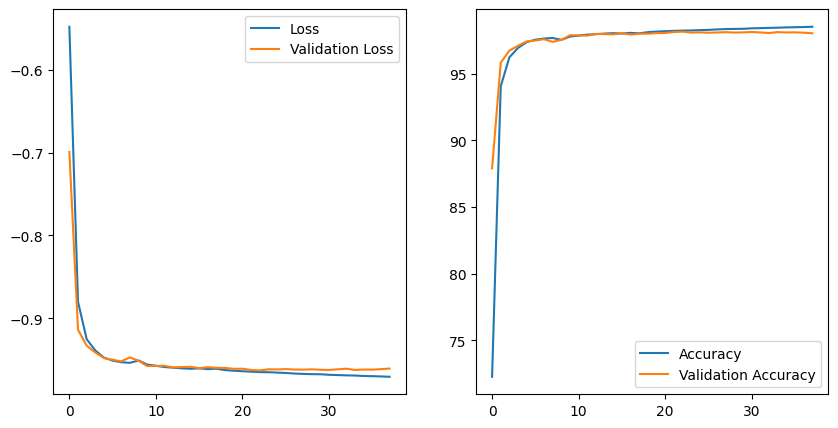

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

3/3 [==============================] - 1s 278ms/step


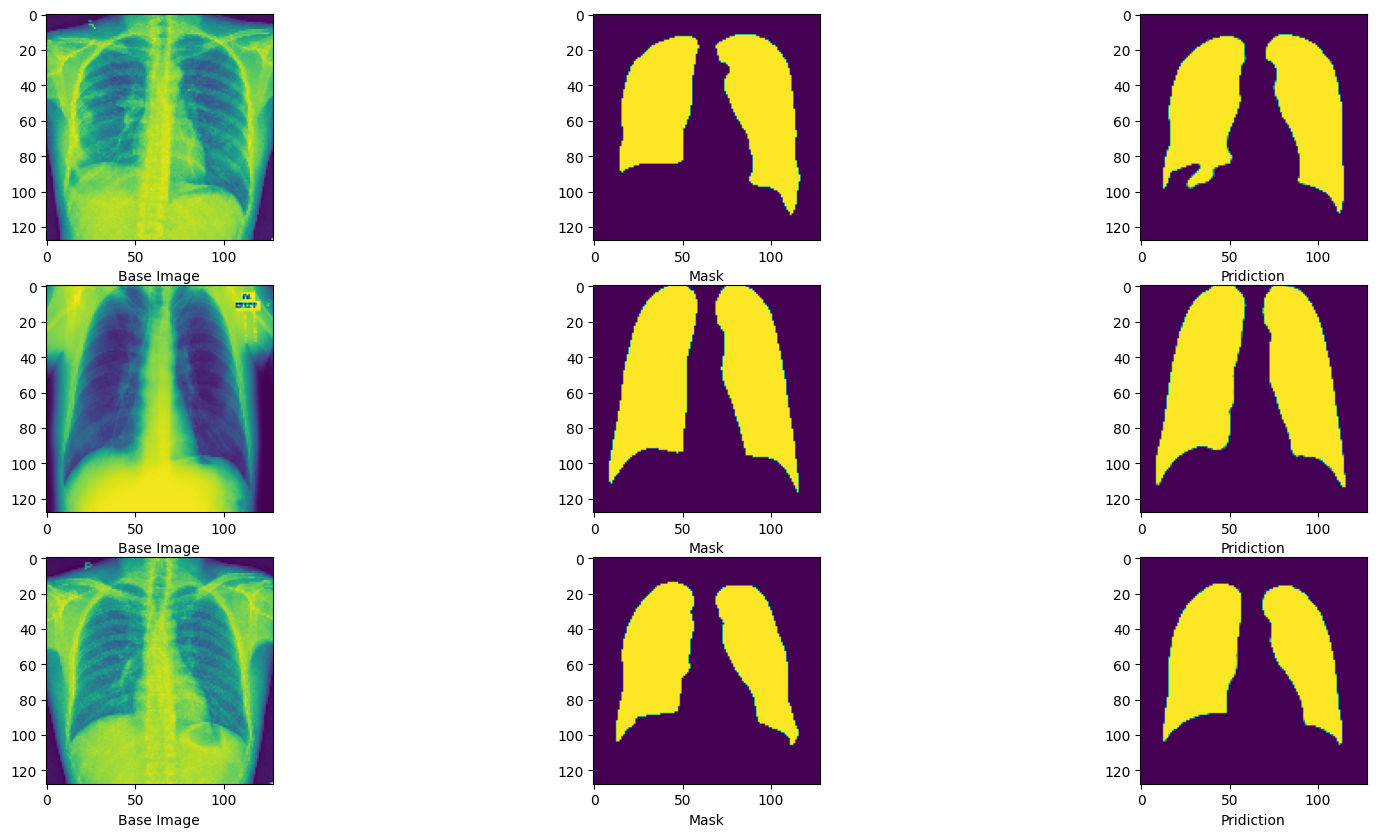

In [18]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")

In [19]:
model.save(path_where_to_save_model+'/segmentation_model.hdf5')

k:\Docs\stage_ingenieur\models\segmentation\virtual_env\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
my_saved_model = load_model(path_where_to_save_model+'/segmentation_model.hdf5')